## Import packages

In [1]:
import numpy as np
import random
import operator 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import time
from pylab import rcParams
import copy
from sklearn.cluster import KMeans
import math
import matplotlib
from statistics import mean, stdev

## Define fitness function for TSP problem

In [2]:
def routeFitness(route, dm):
    dist = 0
    for i in range(len(route)-1):
        dist += dm[route[i], route[i+1]]
    dist += dm[route[-1], route[0]]
    fitness = 1/dist
    
    return fitness

## Define a function to compute euclidean matrix between points

In [3]:
def dist_matrix(df):
    list_of_distances = [] # just to make it simple, probably there are 1k better ways to do this
    for point in df.itertuples():
        a = point[1]
        b = point[2]
        for point_s in df.itertuples():
            c = point_s[1]
            d = point_s[2]
            dist = math.sqrt(((c-a)**2) + ((d-b)**2))
            list_of_distances.append(dist)
    dist_matrix = np.array(list_of_distances) # convertion to array
    dist_matrix = np.reshape(dist_matrix, (len(df), len(df))) # reshaping
    # dist_matrix.shape # check
    return dist_matrix

## Define a function to initialize our population

In [4]:
def initPopulation(popSize, cities):
    population = []
    [population.append(random.sample(cities, len(cities))) for i in range(0, popSize)]
#     for i in range(0, popSize):
#         population.append(createRoute(cityList))
    return population

## Define a function to compute the error

In [5]:
def errPerc(exactValue, currValue, nRound = 2):
    errp = round((abs(exactValue - currValue) / exactValue)*100, nRound)
    return errp

## Define a function to plot our results

In [6]:
def plot(points, path: list, dist, name_tsp, save = False):
    x = []
    y = []
    for point in points.itertuples():
        x.append(point[1])
        y.append(point[2])
    
    y = list(map(operator.sub, [max(y) for i in range(len(points))], y))
    plt.plot(x, y, 'co', markersize = 4, alpha = 0.8)

    for _ in range(1, len(path)):
        i = path[_ - 1]
        j = path[_]

        plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='r',
                  length_includes_head=True, linewidth = 0.3, alpha = 0.8)

    #plt.xlim(0, max(x) * 1.1)

    #plt.ylim(0, max(y) * 1.1)

    label_t = 'Best route for {}'.format(name_tsp)
    label_dist = 'distance: {}'.format(round(dist, 2))
    
    plt.annotate(label_dist, xy=(0.85, 0.98), xycoords='axes fraction')
    plt.title(label_t, loc='center')
    
    if save:
        plt.savefig('figs/best_{}.png'.format(name_tsp), dpi = 300)

## Define the main algorithm

In [7]:
def GenA(permutation, dm, popSize, selection, elite_n, mutation_r, n_of_gen, plot = False, verbose = False):
    start = time.time()
    pop = initPopulation(popSize, permutation)
    fitness = {}
    [fitness.update({i:routeFitness(pop[i], dm)}) for i in range(0,len(pop))]
    rankedRoutes = sorted(fitness.items(), key = operator.itemgetter(1), reverse = True)
    traceBest = 1/rankedRoutes[0][1]
    
    
    if plot:
        progress = []
        progress.append(1 / rankedRoutes[0][1])
    
    if verbose:
        print("Initial distance: " + str(1 / rankedRoutes[0][1]))
    
    for k in range(0, n_of_gen):

        ##################
        # Ranking routes #
        ##################
        
        fitness = {}
        [fitness.update({i:routeFitness(pop[i], dm)}) for i in range(0,len(pop))]
        rankedRoutes = sorted(fitness.items(), key = lambda kv: kv[1], reverse = True)
        if 1/rankedRoutes[0][1] <= traceBest:
            traceBest = 1/rankedRoutes[0][1]
            traceBestRouteIndex = rankedRoutes[0][0]
            traceBestRoute = pop[traceBestRouteIndex]
        ########
        # plot #
        ########
        
        if plot:
            progress.append(1 / rankedRoutes[0][1])

        #############
        # selection #
        #############
        
        if selection == 'roulette-wheel':
            selectionR = []
            df = pd.DataFrame(np.array(rankedRoutes), columns=["Index","Fitness"])
            df['cum_sum'] = df.Fitness.cumsum()
            df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
        
            [selectionR.append(rankedRoutes[i][0]) for i in range(0, elite_n)]
        
            for i in range(0, len(rankedRoutes) - elite_n):
                pick = 100*random.random()
                for i in range(0, len(rankedRoutes)):
                    if pick <= df.iat[i,3]:
                        selectionR.append(rankedRoutes[i][0])
                        break
        
        elif selection == 'tournament':
            selectionR = []
            while len(selectionR) < len(pop):
                fighters = random.sample(rankedRoutes, random.randint(2, len(rankedRoutes)))
                winner = max(fighters, key = operator.itemgetter(1))[0]
                selectionR.append(winner)
                
                # deprecated code
                
#                 fighter_1 = fighters[0]
#                 fighter_2 = fighters[1]
#                 if fighter_1[1] >= fighter_2[1]:
#                     winner = fighter_1[0]
#                 else:
#                     winner = fighter_2[0]
#                 selectionR.append(winner)
#             del rank
#             df = pd.DataFrame(np.array(rankedRoutes), columns=["Index","Fitness"])
#             df['cum_sum'] = df.Fitness.cumsum()
#             df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
#             for i in range(0, len(rankedRoutes) - elite_n):
#                 pick = 100*random.random()
#                 for i in range(0, len(rankedRoutes)):
#                     if pick <= df.iat[i,3]:
#                         selectionR.append(rankedRoutes[i][0])
#                         break
        else:
            print("Only roulette-wheel and tournament are suitable selection options")
            break
            
        ###############
        # mating pool #
        ###############
        
        mp = []
        [mp.append(pop[selectionR[i]]) for i in range(0, len(selectionR))]

        #############
        # Crossover #
        #############
        
        children = []
        length = (len(mp) - elite_n)
        pool = random.sample(mp, len(mp))
        [children.append(mp[i]) for i in range(0, elite_n)]
        
        for i in range(0, length):
            parent1 = pool[i]
            parent2 = pool[len(mp)-i-1]
            child = []
            childP1 = []
            childP2 = []
    
            geneA = int(random.random() * len(parent1))
            geneB = int(random.random() * len(parent1))
            
            startGene = min(geneA, geneB)
            endGene = max(geneA, geneB)
            [childP1.append(parent1[i]) for i in range(startGene, endGene)]
            childP2 = [item for item in parent2 if item not in childP1]
            
            child = childP1 + childP2
            children.append(child)
        
        ############
        # mutation #
        ############
        
        mutatedPop = []
    
        for ind in range(0, len(children)):
            individual = children[ind]
            for swapped in range(len(individual)):
                if(random.random() < mutation_r):
                    swapWith = int(random.random() * len(individual))
            
                    city1 = individual[swapped]
                    city2 = individual[swapWith]
            
                    individual[swapped] = city2
                    individual[swapWith] = city1
            mutatedPop.append(individual)
        
        ##############
        # update pop #
        ##############
        
        pop = mutatedPop
        
    
    
    ###########
    # results #
    ###########
    
    fitness = {}
    [fitness.update({i:routeFitness(pop[i], dm)}) for i in range(0,len(pop))]
    rankedRoutes = sorted(fitness.items(), key = lambda kv: kv[1], reverse = True)
    
    if 1/rankedRoutes[0][1] <= traceBest:
        traceBest = 1/rankedRoutes[0][1]
        traceBestRouteIndex = rankedRoutes[0][0]
        traceBestRoute = pop[traceBestRouteIndex]
        bestDistance = traceBest #1 / rankedRoutes[0][1]
        bestRouteIndex = traceBestRouteIndex #rankedRoutes[0][0]
        bestRoute = traceBestRoute #pop[bestRouteIndex]
    else:
        bestDistance = traceBest #1 / rankedRoutes[0][1]
        bestRouteIndex = traceBestRouteIndex #rankedRoutes[0][0]
        bestRoute = traceBestRoute #pop[bestRouteIndex]
        
    #bestDistance = traceBest #1 / rankedRoutes[0][1]
    if verbose:
        print("Final distance: {}".format(bestDistance))
    #bestRouteIndex = traceBestRouteIndex #rankedRoutes[0][0]
    #bestRoute = traceBestRoute #pop[bestRouteIndex]
    time_executed = (time.time() - start)
    
    if verbose:
        print("Algorithm completed in {} s".format(time_executed))
    
    if plot:
        rcParams['figure.figsize'] = 15, 5
        plt.plot(progress)
        plt.ylabel('Distance')
        plt.xlabel('Generation')
        plt.show()
    
    return bestRoute, bestDistance, time_executed

## Data

Import our data

In [8]:
df_dj38 = pd.read_csv("data/dj38.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
df_berlin52 = pd.read_csv("data/berlin52.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
df_ch130 = pd.read_csv("data/ch130.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
df_d198 = pd.read_csv("data/d198.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
df_pr1002 = pd.read_csv("data/pr1002.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)


bestKnown_tsp = {
    'dj38':6656,
    'berlin52':7542,
    'ch130':6110,
    'd198':15780,
    'pr1002':259045}

#list for final results
list_dist_avg = []
list_dist_best = []
list_dist_std = []
list_time_avg = []
list_route_final = []
list_errp_avg = []
list_errp_best = []

#init number of run for each algortihm
nRun = 5

## GA

### dj38

In [51]:
cities = []
cities = list(range(len(df_dj38)))
d_matrix = dist_matrix(df_dj38)

Initial distance: 22573.001955297204
Final distance: 6734.030407341293
Algorithm completed in 104.66638541221619 s


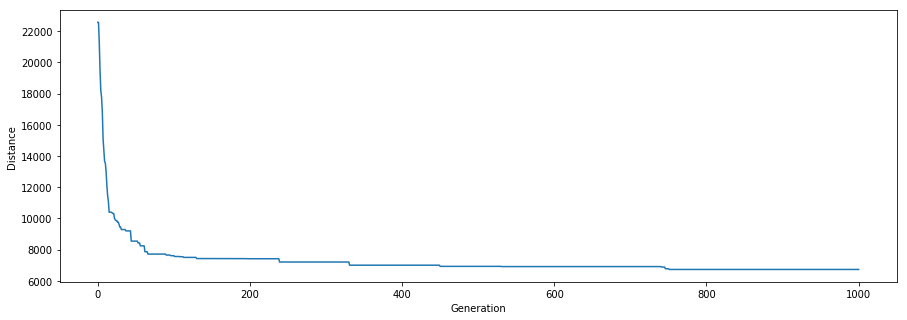

Initial distance: 22762.717431875022
Final distance: 7313.656683894849
Algorithm completed in 111.67058372497559 s


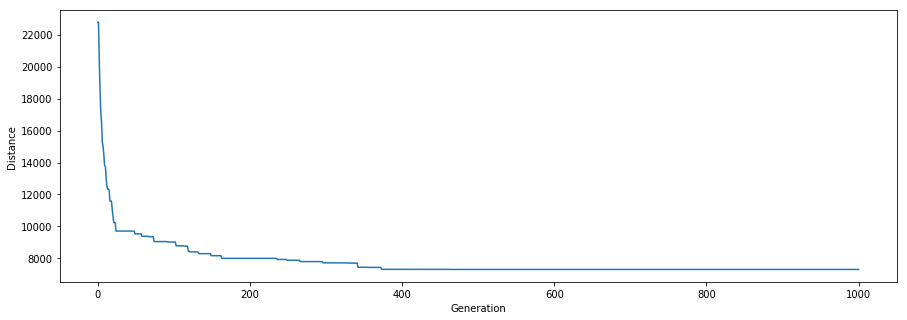

Initial distance: 21972.987251917548
Final distance: 6659.906740386758
Algorithm completed in 123.05780029296875 s


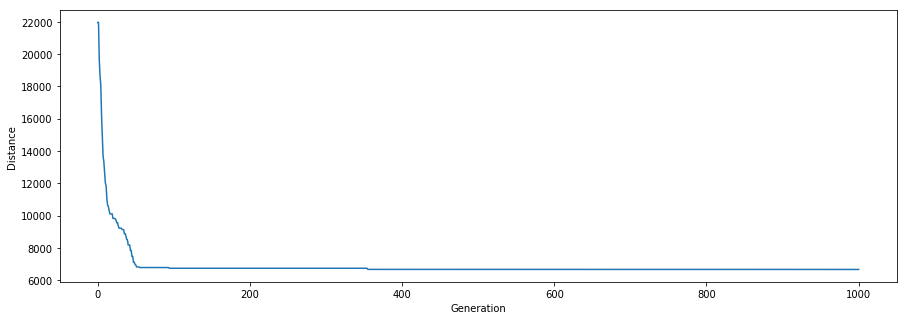

Initial distance: 22628.615088787526
Final distance: 6862.292177213451
Algorithm completed in 154.47826981544495 s


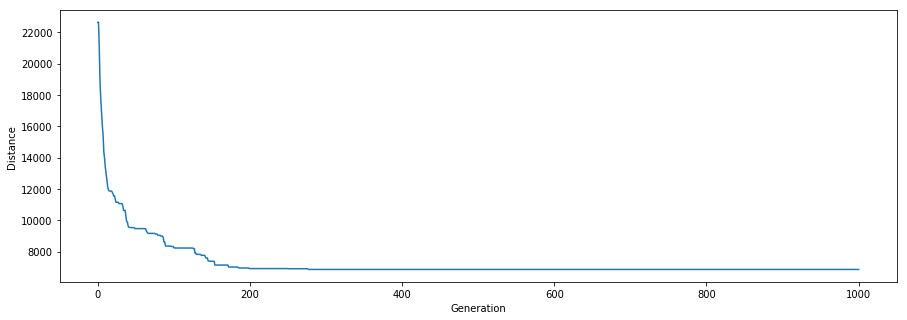

Initial distance: 20912.5988268608
Final distance: 8351.420930704255
Algorithm completed in 98.91993355751038 s


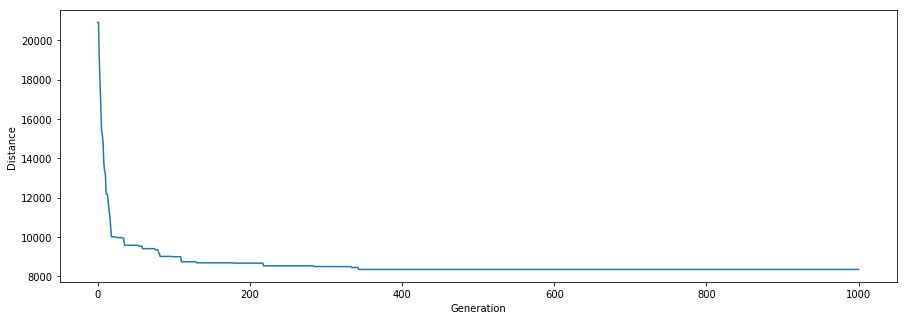

In [59]:
list_dist = []
list_time = []
list_errp = []
list_route = []

#for save best route
best = 99999999

for run in range(0,nRun):
    route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                             popSize = 300,
                             selection = 'tournament',
                             elite_n = 30,
                             mutation_r = 0.01,
                             n_of_gen = 1000,
                               plot = True,
                               verbose = True)

    errp = errPerc(bestKnown_tsp['dj38'], dist, 2)
    #print('With an error to minimal value of: {}%'.format(errp))
    list_dist.append(dist)
    list_time.append(time_ex)
    list_errp.append(errp)
    
    
    if dist < best:
        list_route = route
        best = dist
    
#insert in list for final results (best, mean, std)
list_dist_avg.append(mean(list_dist))
list_dist_best.append(min(list_dist))
list_dist_std.append(stdev(list_dist))
list_errp_avg.append(mean(list_errp))
list_errp_best.append(errPerc(bestKnown_tsp['dj38'], min(list_dist), 2))
list_time_avg.append(mean(list_time))
list_route_final.append(list_route)

In [60]:
list_errp_avg, list_dist_avg, list_errp_best, list_dist_best #150 Ps, 125 Ps, 300 Ps + 30 elite,

([17.234, 15.504000000000001, 7.936],
 [7803.042550046753, 7687.7531409357825, 7184.261387908121],
 [4.31, 9.07, 0.06],
 [6942.6609633314965, 7259.415403527026, 6659.906740386758])

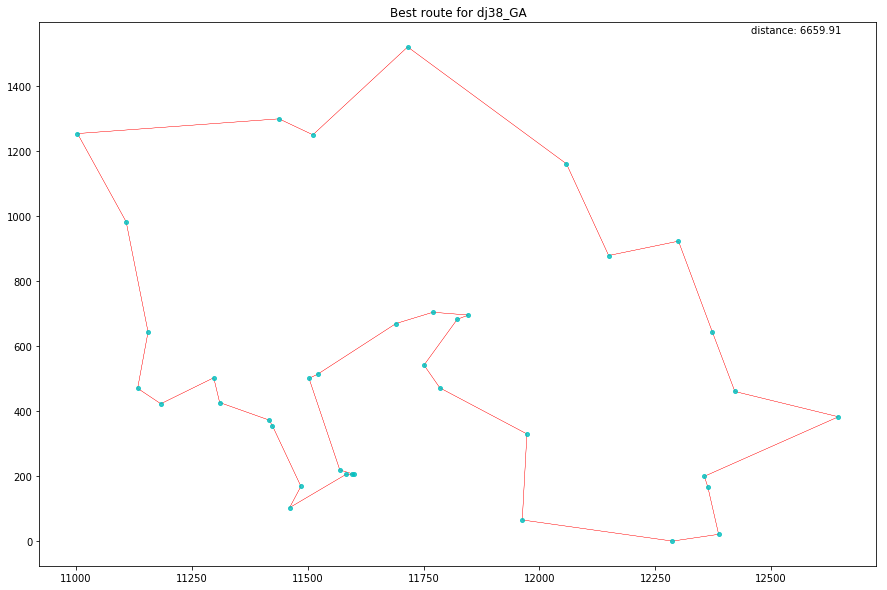

In [62]:
rcParams['figure.figsize'] = 15,10
plot(df_dj38, list_route_final[2], list_dist_best[2], 'dj38_GA', save = False)

### berlin52

In [68]:
cities = []
cities = list(range(len(df_berlin52)))
d_matrix = dist_matrix(df_berlin52)

Initial distance: 26613.867658741026
Final distance: 8701.81126645096
Algorithm completed in 16.888354301452637 s


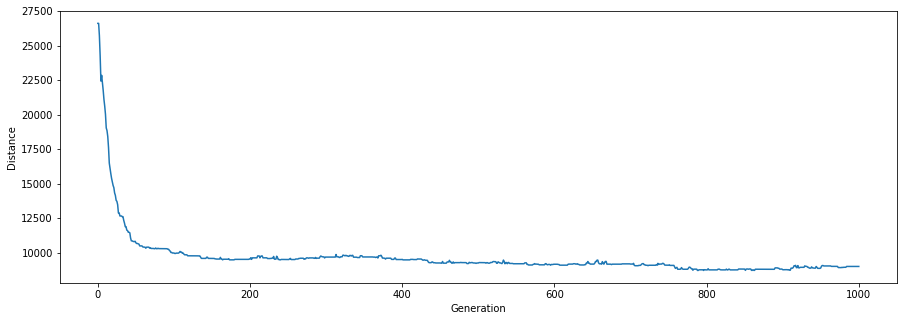

Initial distance: 25474.883114128417
Final distance: 8748.346737750426
Algorithm completed in 20.467310190200806 s


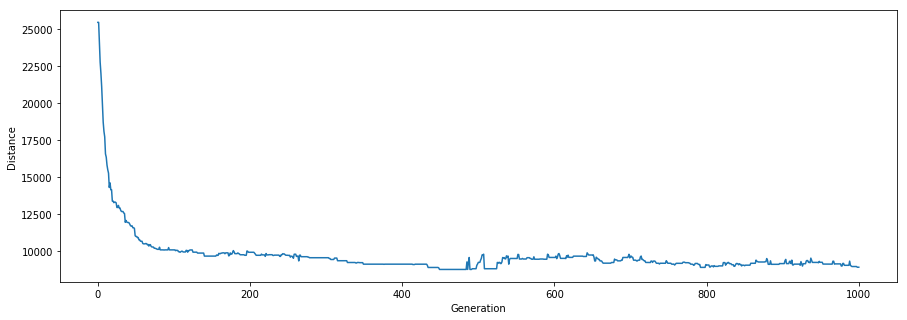

Initial distance: 24622.51255898178
Final distance: 8500.089270770894
Algorithm completed in 19.589908123016357 s


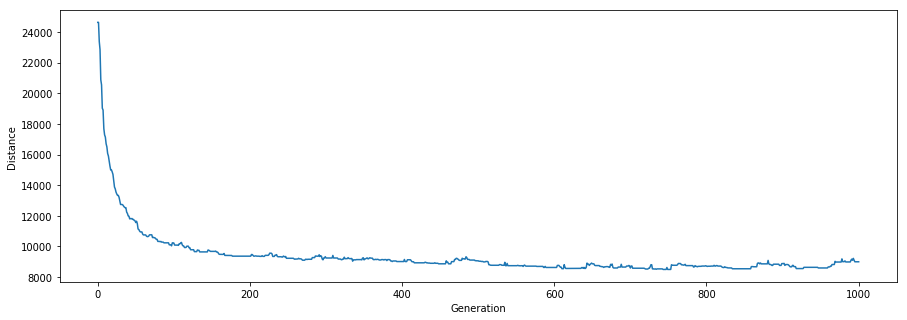

Initial distance: 26233.553524393363
Final distance: 9212.59147673795
Algorithm completed in 21.816527605056763 s


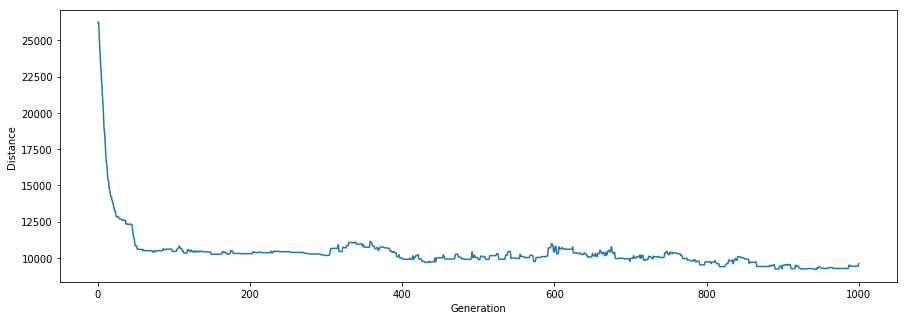

Initial distance: 25304.622568364735
Final distance: 8914.333175910375
Algorithm completed in 17.126217365264893 s


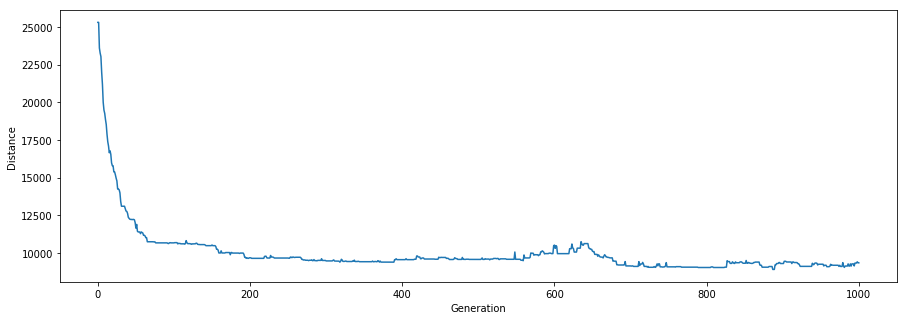

In [73]:
list_dist = []
list_time = []
list_errp = []
list_route = []

#for save best route
best = 99999999

for run in range(0,nRun):
    route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                             popSize = 300,
                             selection = 'tournament',
                             elite_n = 30,
                             mutation_r = 0.01,
                             n_of_gen = 1000,
                               plot = True,
                               verbose = True)

    errp = errPerc(bestKnown_tsp['berlin52'], dist, 2)
    #print('With an error to minimal value of: {}%'.format(errp))
    list_dist.append(dist)
    list_time.append(time_ex)
    list_errp.append(errp)
    
    
    if dist < best:
        list_route = route
        best = dist
    
#insert in list for final results (best, mean, std)
list_dist_avg.append(mean(list_dist))
list_dist_best.append(min(list_dist))
list_dist_std.append(stdev(list_dist))
list_errp_avg.append(mean(list_errp))
list_errp_best.append(errPerc(bestKnown_tsp['berlin52'], min(list_dist), 2))
list_time_avg.append(mean(list_time))
list_route_final.append(list_route)

In [74]:
list_errp_avg, list_dist_avg, list_errp_best, list_dist_best #300 ps + 30 elit, 150 + 25, 100 + 25

([16.442, 14.405999999999999, 16.886],
 [8782.097959332244, 8628.339163224693, 8815.43438552412],
 [12.36, 12.19, 12.7],
 [8474.510045570514, 8461.091543517254, 8500.089270770894])

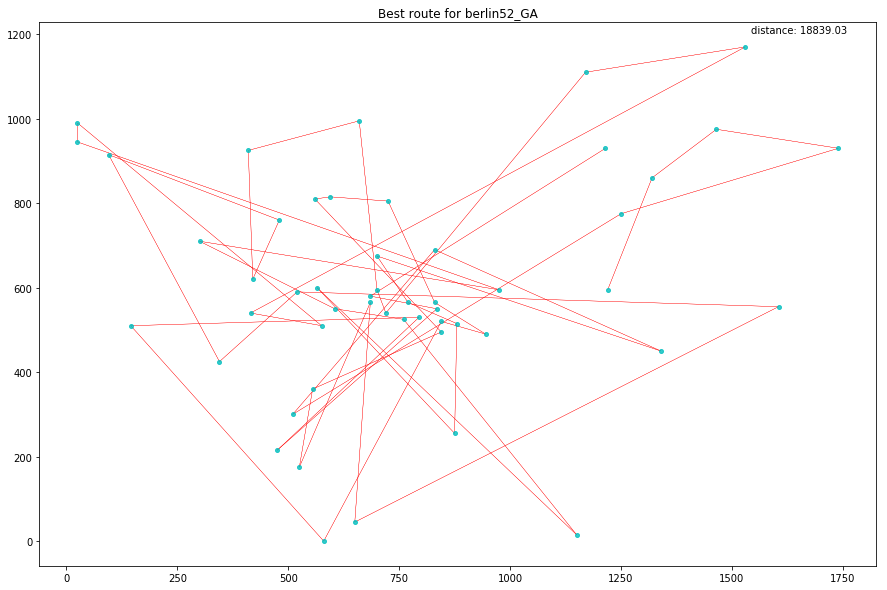

In [14]:
rcParams['figure.figsize'] = 15,10
plot(df_berlin52, route, dist, 'berlin52_GA', save = False)

### ch130

In [122]:
cities = []
cities = list(range(len(df_ch130)))
d_matrix = dist_matrix(df_ch130)

In [127]:
list_dist = []
list_time = []
list_errp = []
list_route = []

#for save best route
best = 99999999

for run in range(0,nRun):
    route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                             popSize = 300,
                             selection = 'tournament',
                             elite_n = 30,
                             mutation_r = 0.01,
                             n_of_gen = 1000,
                               plot = False,
                               verbose = False)

    errp = errPerc(bestKnown_tsp['ch130'], dist, 2)
    #print('With an error to minimal value of: {}%'.format(errp))
    list_dist.append(dist)
    list_time.append(time_ex)
    list_errp.append(errp)
    
    
    if dist < best:
        list_route = route
        best = dist
    
#insert in list for final results (best, mean, std)
list_dist_avg.append(mean(list_dist))
list_dist_best.append(min(list_dist))
list_dist_std.append(stdev(list_dist))
list_errp_avg.append(mean(list_errp))
list_errp_best.append(errPerc(bestKnown_tsp['ch130'], min(list_dist), 2))
list_time_avg.append(mean(list_time))
list_route_final.append(list_route)

In [128]:
list_errp_avg, list_dist_avg, list_errp_best, list_dist_best #100 + 25, 150 + 25, 300 + 30, 

([217.738, 195.52800000000002, 147.62199999999999],
 [19413.94548242774, 18056.80005630384, 15129.519805661064],
 [214.14, 183.55, 131.98],
 [19193.966798176232, 17324.74602374021, 14173.723938821428])

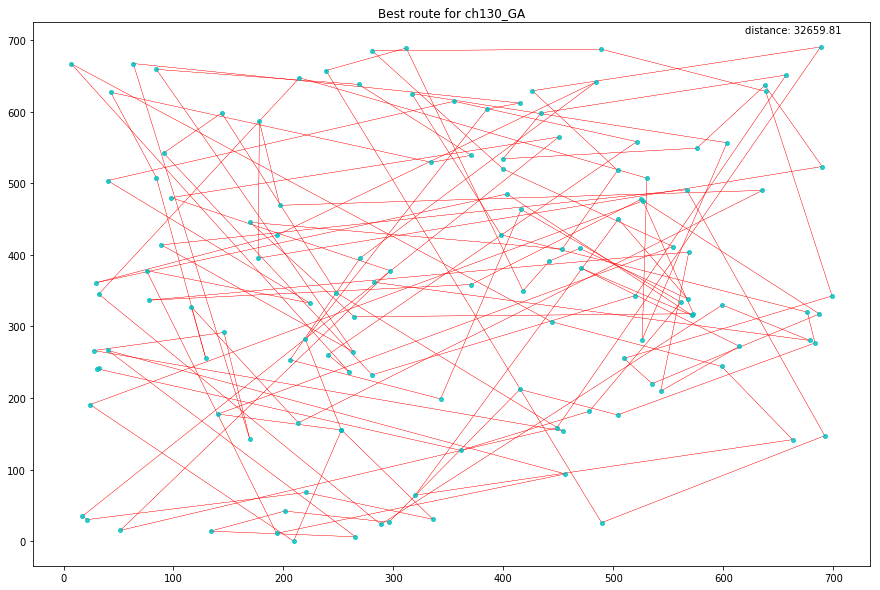

In [17]:
rcParams['figure.figsize'] = 15,10
plot(df_ch130, route, dist, 'ch130_GA', save = False)

### d198

In [130]:
cities = []
cities = list(range(len(df_d198)))
d_matrix = dist_matrix(df_d198)

In [137]:
list_dist = []
list_time = []
list_errp = []
list_route = []

#for save best route
best = 99999999

for run in range(0,nRun):
    route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                             popSize = 300,
                             selection = 'tournament',
                             elite_n = 30,
                             mutation_r = 0.01,
                             n_of_gen = 1000,
                               plot = False,
                               verbose = False)

    errp = errPerc(bestKnown_tsp['d198'], dist, 2)
    #print('With an error to minimal value of: {}%'.format(errp))
    list_dist.append(dist)
    list_time.append(time_ex)
    list_errp.append(errp)
    
    
    if dist < best:
        list_route = route
        best = dist
    
#insert in list for final results (best, mean, std)
list_dist_avg.append(mean(list_dist))
list_dist_best.append(min(list_dist))
list_dist_std.append(stdev(list_dist))
list_errp_avg.append(mean(list_errp))
list_errp_best.append(errPerc(bestKnown_tsp['d198'], min(list_dist), 2))
list_time_avg.append(mean(list_time))
list_route_final.append(list_route)

In [138]:
list_errp_avg, list_dist_avg, list_errp_best, list_dist_best #100+25, 300+30, 300+30*1k, 125+25*1k

([326.88, 232.546, 98.984, 150.08],
 [67361.68972875086, 52475.7909406996, 31399.634738568755, 39462.880582251884],
 [286.13, 190.72, 86.78, 142.0],
 [60931.516547437874, 45875.57048117937, 29473.928510177, 38187.84710608375])

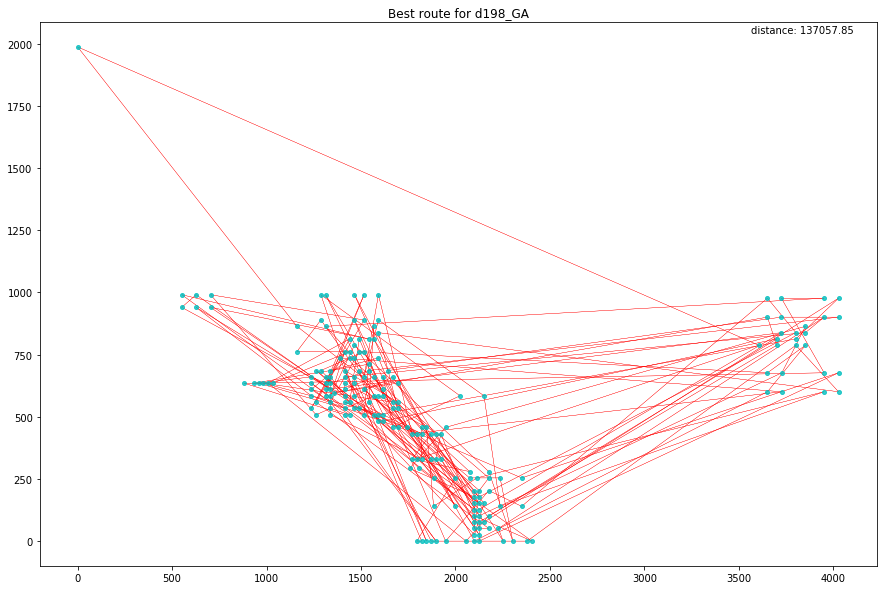

In [20]:
rcParams['figure.figsize'] = 15,10
plot(df_d198, route, dist, 'd198_GA', save = False)

### pr1002

In [21]:
cities = []
cities = list(range(len(df_pr1002)))
d_matrix = dist_matrix(df_pr1002)

In [22]:
list_dist = []
list_time = []
list_errp = []
list_route = []

#for save best route
best = 99999999

for run in range(0,nRun):
    route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                             popSize = 100,
                             selection = 'tournament',
                             elite_n = 25,
                             mutation_r = 0.01,
                             n_of_gen = 1,
                               plot = False,
                               verbose = False)

    errp = errPerc(bestKnown_tsp['pr1002'], dist, 2)
    #print('With an error to minimal value of: {}%'.format(errp))
    list_dist.append(dist)
    list_time.append(time_ex)
    list_errp.append(errp)
    
    
    if dist < best:
        list_route = route
        best = dist
    
#insert in list for final results (best, mean, std)
list_dist_avg.append(mean(list_dist))
list_dist_best.append(min(list_dist))
list_dist_std.append(stdev(list_dist))
list_errp_avg.append(mean(list_errp))
list_errp_best.append(errPerc(bestKnown_tsp['pr1002'], min(list_dist), 2))
list_time_avg.append(mean(list_time))
list_route_final.append(list_route)

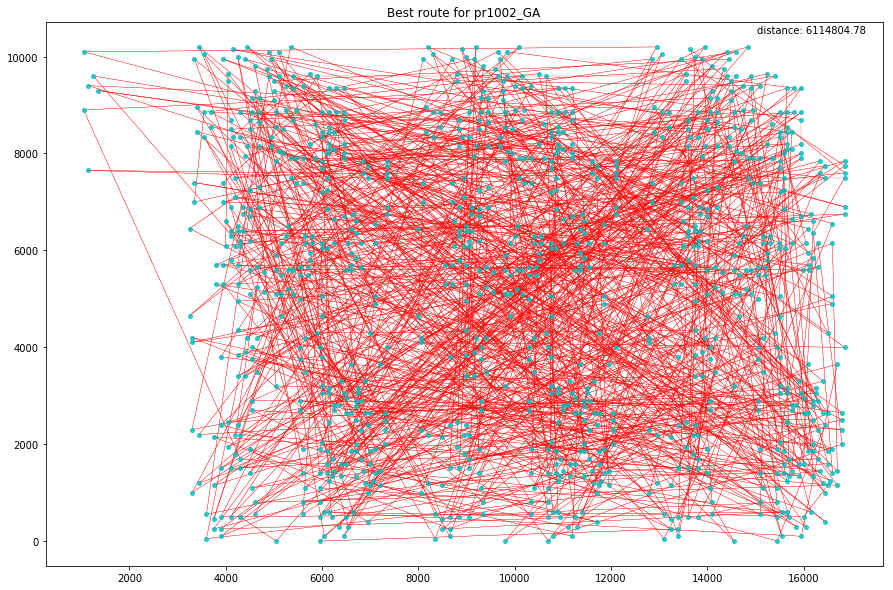

In [23]:
rcParams['figure.figsize'] = 15,10
plot(df_pr1002, route, dist, 'pr1002_GA', save = False)

## Results for GA

In [9]:
ndx = list(bestKnown_tsp.keys())

In [10]:
 #OptimalTour, mean, sd, best, %minDist, %bestDist, avgTime(s)

In [26]:
list_best_dist_known = list(bestKnown_tsp.values())
list_tuples = list(zip(list_best_dist_known,list_dist_avg, list_dist_std, list_dist_best, list_errp_avg,
                      list_errp_best, list_time_avg))
results_GA = pd.DataFrame(list_tuples, columns = ['OptimalTour', 'mean_GA', 'sd_GA', 'best_GA', '%meanDist_GA',
                                                 '%bestDist_GA', 'avgTime(s)_GA'], index = ndx)

pd.options.display.float_format = '{:.2f}'.format
results_GA


,OptimalTour,mean_GA,sd_GA,best_GA,%meanDist_GA,%bestDist_GA,avgTime(s)_GA
dj38,6656,14868.04,405.34,14234.01,123.38,113.85,0.16
berlin52,7542,18141.91,548.96,17527.20,140.54,132.39,0.19
ch130,6110,32703.79,519.60,31921.29,435.25,422.44,0.38
d198,15780,131782.66,3313.13,128903.40,735.12,716.88,0.62
pr1002,259045,6134500.29,28304.42,6114804.78,2268.12,2260.52,0.98


In [27]:
#save the route of best distance 
with open("BestRoute_GA.txt", "w") as text_file:
    c = 0
    for i in results_GA.index:
        print("The best route for {} is:\n{}\n\n".format(i, list_route_final[c]), file=text_file)
        c += 1

## K-means with GA (KGA)

First of all we define a function that create a list of clusters

In [11]:
def list_of_clusters(kMeans_results):
    list_of_clusters = []
    for i in range(0, len(np.unique(kMeans_results))):
        tmp = np.where(kMeans_results == i)[0].tolist()
        list_of_clusters.append(tmp)
               
    return list_of_clusters

With KGA we use GA inside every cluster we created

In [12]:
def KGA(list_of_clusters, dm, popSize, selection, elite_n, mutation_r, n_of_gen, plot):
    listClusterRoute = []
    for elem in list_of_clusters:
        tmpBestRoute = GenA(permutation = elem, dm = dm,
                         popSize = popSize,
                         selection = selection,
                         elite_n = elite_n,
                         mutation_r = mutation_r,
                         n_of_gen = n_of_gen,
                           plot = plot)[0]
        
        # plot(df_dj38, tmpBestRoute, 'dj38Partial')
        listClusterRoute.append(tmpBestRoute)
    return listClusterRoute

With join_cluster we re-construct the entire list of cities from the previous cluster

In [13]:
def join_cluster(clu1, clu2, d_matrix):
    value = None
    for i in range(len(clu1)):
        for j in range(len(clu2)):
            tmp = d_matrix[clu1[i],clu2[j]]
            if value is None:
                value=tmp
                i_min= i
                j_min = j
            if tmp < value:
                value = tmp
                i_min= i
                j_min = j

    i_min1 = i_min - 1

    j_min1 = j_min -1

    if i_min != len(clu1)-1:
        i_plu1 = i_min + 1
    else:
        i_plu1 = 0

    if j_min != len(clu2)-1:
        j_plu1 = j_min + 1
    else:
        j_plu1 = 0

    #list1 = [clu1[i_min1], clu1[i_plu1]]
    #list2 = [clu2[j_min1], clu2[j_plu1]]

    del tmp
    carlo = np.array([i_min1, i_plu1, j_min1, j_plu1]).reshape(2,2)
    # carlo
    d_ij = d_matrix[clu1[i_min], clu2[j_min]]
    #print(carlo)
    best_norm=None
    best_ip = 0
    best_jp = 0
    for i in carlo[0]:
        d_iip = d_matrix[clu1[i_min], clu1[i]]
        d_ipj = d_matrix[clu2[j_min], clu1[i]]
        for j in carlo[1]:
            
            d_jjp = d_matrix[clu2[j_min], clu2[j]]
            d_ijp = d_matrix[clu1[i_min], clu2[j]]
            d_ipjp = d_matrix[clu1[i], clu2[j]]
            tmp  = d_ij + d_ipjp-d_iip-d_jjp
            tmp1 = d_ijp + d_ipj -d_iip-d_jjp
            n_tmp= math.pow(math.pow(tmp,2)+math.pow(tmp1,2), 1/2 )

            if best_norm is None:
                #print(tmp, tmp1, n_tmp)
                best_norm=n_tmp
                best_jp=j
                best_ip=i

            elif n_tmp < best_norm:
                best_norm=n_tmp
                best_jp=j
                best_ip=i

    #print(carlo,best_ip, best_jp)

    new_seq_i=clu1[best_ip:]+clu1[:best_ip]
    new_seq_j=clu2[best_jp:]+clu2[:best_jp]


    tot_seq_ipjpbestcarlos=new_seq_i+new_seq_j
    return tot_seq_ipjpbestcarlos

# Benchmark KGA

In [111]:
#list for final results
list_dist_avg = []
list_dist_best = []
list_dist_std = []
list_time_avg = []
list_route_final = []
list_errp_avg = []
list_errp_best = []

#init number of run for each algortihm
#nRun = 5

### dj38

In [85]:
d_matrix = dist_matrix(df_dj38)

list_dist = []
list_time = []
list_route = None
list_errp = []


best = 99999999
for run in range(0,nRun):

    #time
    start = time.time()


    ###########
    # cluster #
    ###########

    clustering = KMeans(n_clusters = 2, n_init = 100).fit(df_dj38)
    results = clustering.labels_

    centroid_df = pd.DataFrame(clustering.cluster_centers_)
    centroids = []
    centroids = list(range(len(centroid_df)))
    d_matrixCentroid = dist_matrix(centroid_df)

    #1/routeFitness(centroids, d_matrixCentroid)

    #order cluster with shortest path (GA)
    ordered_centroids = GenA(centroids,
                             d_matrixCentroid, 
                             popSize = 100,
                             selection = 'roulette-wheel',
                             elite_n=25,
                             mutation_r=0.01,
                             n_of_gen = 1000)[0]
    # and re-order
    obj = list_of_clusters(results)
    obj1 = []
    [obj1.append(obj[elem]) for elem in ordered_centroids]
    #print('done')


    ##################
    # GA --> cluster #
    ##################

    Clusterdj38 = KGA(obj1,
                      dm = d_matrix,
                      popSize=100,
                      selection='roulette-wheel',
                      elite_n=25,
                      mutation_r=0.01,
                      n_of_gen=100,
                      plot = False)


    ################
    # join cluster #
    ################

    clu_start = Clusterdj38[0]
    for i in range(1,len(Clusterdj38)):
        clu_start = join_cluster(clu_start,Clusterdj38[i], d_matrix)

    dist = 1/routeFitness(clu_start, d_matrix)

    end = time.time()
    time_ex = end-start

    
    if dist < best:
        list_route = clu_start[:]
        best = dist

    errp = errPerc(bestKnown_tsp['dj38'], dist, 2)
    # print(dist)
    # print('With an error to minimal value of: {}%'.format(errp))
    list_dist.append(dist)
    list_time.append(time_ex)
    list_errp.append(errp)





#insert in list for final results (best, mean, std)
list_dist_avg.append(mean(list_dist))
list_dist_best.append(min(list_dist))
list_dist_std.append(stdev(list_dist))
list_errp_avg.append(mean(list_errp))
list_errp_best.append(errPerc(bestKnown_tsp['dj38'], min(list_dist), 2))
list_time_avg.append(mean(list_time))
list_route_final.append(list_route)

c:\users\massi\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [86]:
list_errp_avg, list_dist_avg, list_errp_best, list_dist_best #k=2, k=3, k=4, k=38

([40.698, 54.638, 46.482, 181.868, 150.87199999999999],
 [9364.816021112942,
  10292.677668239128,
  9749.758471855275,
  18761.11389730397,
  16697.971677379905],
 [18.15, 45.6, 33.89, 122.32, 133.88],
 [7864.123360115586,
  9690.997751695973,
  8911.85667857357,
  14797.306759003108,
  15567.200505161607])

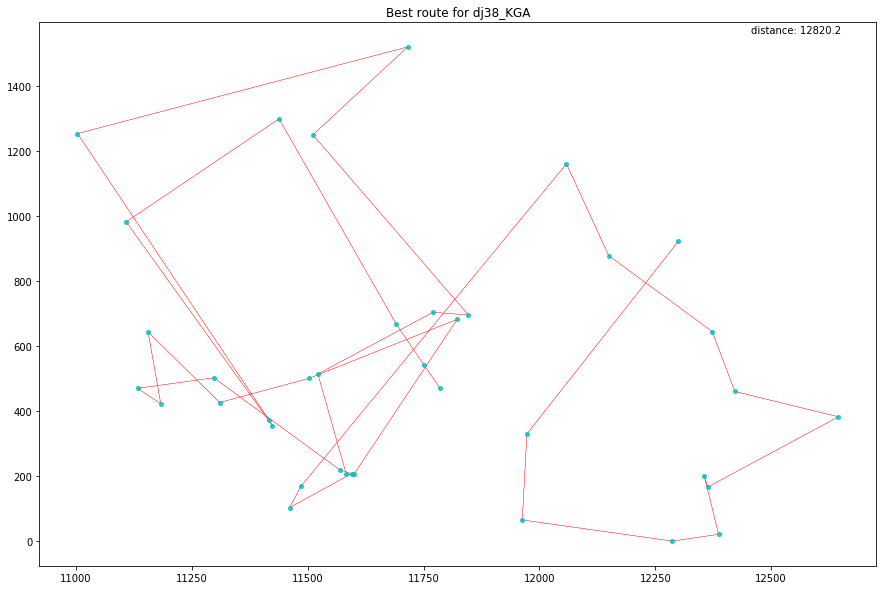

In [33]:
rcParams['figure.figsize'] = 15,10
plot(df_dj38, clu_start, dist, 'dj38_KGA', save = False)

### berlin52

In [98]:
d_matrix = dist_matrix(df_berlin52)

list_dist = []
list_time = []
list_route = None
list_errp = []


best = 99999999
for run in range(0,nRun):

    #time
    start = time.time()


    ###########
    # cluster #
    ###########

    clustering = KMeans(n_clusters = 3, n_init = 100).fit(df_berlin52)
    results = clustering.labels_

    centroid_df = pd.DataFrame(clustering.cluster_centers_)
    centroids = []
    centroids = list(range(len(centroid_df)))
    d_matrixCentroid = dist_matrix(centroid_df)

    #1/routeFitness(centroids, d_matrixCentroid)

    #order cluster with shortest path (GA)
    ordered_centroids = GenA(centroids,
                             d_matrixCentroid, 
                             popSize = 100,
                             selection = 'roulette-wheel',
                             elite_n=25,
                             mutation_r=0.01,
                             n_of_gen = 100)[0]
    # and re-order
    obj = list_of_clusters(results)
    obj1 = []
    [obj1.append(obj[elem]) for elem in ordered_centroids]
    #print('done')


    ##################
    # GA --> cluster #
    ##################

    Clusterberlin52 = KGA(obj1,
                      dm = d_matrix,
                      popSize=100,
                      selection='roulette-wheel',
                      elite_n=25,
                      mutation_r=0.01,
                      n_of_gen=100,
                      plot = False)


    ################
    # join cluster #
    ################

    clu_start = Clusterberlin52[0]
    for i in range(1,len(Clusterberlin52)):
        clu_start = join_cluster(clu_start,Clusterberlin52[i], d_matrix)

    dist = 1/routeFitness(clu_start, d_matrix)

    end = time.time()
    time_ex = end-start

    
    if dist < best:
        list_route = clu_start[:]
        best = dist

    errp = errPerc(bestKnown_tsp['berlin52'], dist, 2)
    # print(dist)
    # print('With an error to minimal value of: {}%'.format(errp))
    list_dist.append(dist)
    list_time.append(time_ex)
    list_errp.append(errp)





#insert in list for final results (best, mean, std)
list_dist_avg.append(mean(list_dist))
list_dist_best.append(min(list_dist))
list_dist_std.append(stdev(list_dist))
list_errp_avg.append(mean(list_errp))
list_errp_best.append(errPerc(bestKnown_tsp['berlin52'], min(list_dist), 2))
list_time_avg.append(mean(list_time))
list_route_final.append(list_route)

In [99]:
list_errp_avg, list_dist_avg, list_errp_best, list_dist_best #k=6, k=10, k=15, k=3, k=2, k=3

([46.622, 43.116, 51.538, 31.406000000000002, 65.852, 29.816],
 [11058.228268674138,
  10793.90457396925,
  11429.110617259656,
  9910.666088960226,
  12508.635032493068,
  9790.618123935934],
 [38.33, 26.37, 44.94, 17.28, 47.7, 21.75],
 [10433.154523531799,
  9530.931270236448,
  10931.741567997553,
  8845.315090776538,
  11139.723456139673,
  9182.274549019643])

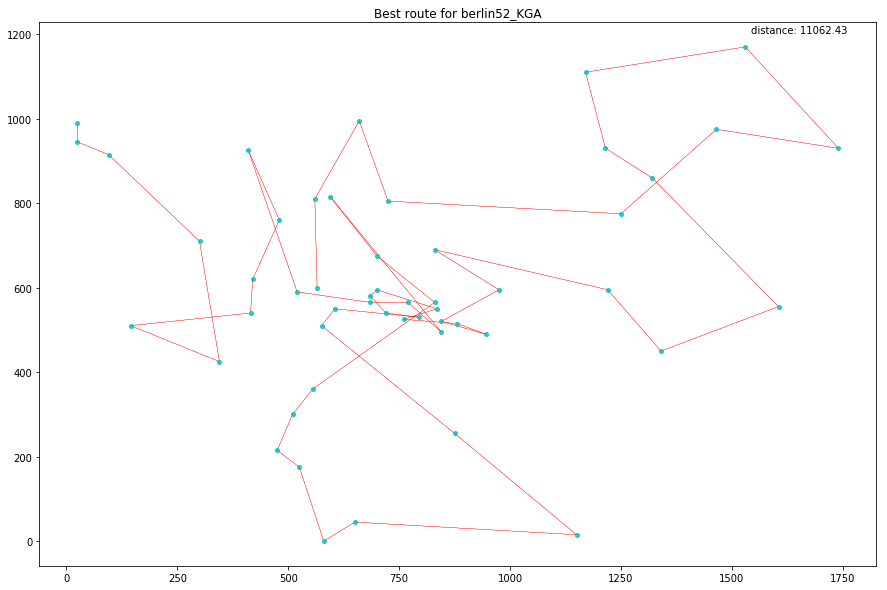

In [35]:
rcParams['figure.figsize'] = 15,10
plot(df_berlin52, clu_start, dist, 'berlin52_KGA', save = False)

### ch 130

In [109]:
d_matrix = dist_matrix(df_ch130)

list_dist = []
list_time = []
list_route = None
list_errp = []


best = 99999999
for run in range(0,nRun):

    #time
    start = time.time()


    ###########
    # cluster #
    ###########

    clustering = KMeans(n_clusters = 10, n_init = 100).fit(df_ch130)
    results = clustering.labels_

    centroid_df = pd.DataFrame(clustering.cluster_centers_)
    centroids = []
    centroids = list(range(len(centroid_df)))
    d_matrixCentroid = dist_matrix(centroid_df)

    #1/routeFitness(centroids, d_matrixCentroid)

    #order cluster with shortest path (GA)
    ordered_centroids = GenA(centroids,
                             d_matrixCentroid, 
                             popSize = 100,
                             selection = 'roulette-wheel',
                             elite_n=25,
                             mutation_r=0.01,
                             n_of_gen = 100)[0]
    # and re-order
    obj = list_of_clusters(results)
    obj1 = []
    [obj1.append(obj[elem]) for elem in ordered_centroids]
    #print('done')


    ##################
    # GA --> cluster #
    ##################

    Clusterch130 = KGA(obj1,
                      dm = d_matrix,
                      popSize=100,
                      selection='roulette-wheel',
                      elite_n=25,
                      mutation_r=0.01,
                      n_of_gen=100,
                      plot = False)


    ################
    # join cluster #
    ################

    clu_start = Clusterch130[0]
    for i in range(1,len(Clusterch130)):
        clu_start = join_cluster(clu_start,Clusterch130[i], d_matrix)

    dist = 1/routeFitness(clu_start, d_matrix)

    end = time.time()
    time_ex = end-start

    
    if dist < best:
        list_route = clu_start[:]
        best = dist

    errp = errPerc(bestKnown_tsp['ch130'], dist, 2)
    # print(dist)
    # print('With an error to minimal value of: {}%'.format(errp))
    list_dist.append(dist)
    list_time.append(time_ex)
    list_errp.append(errp)





#insert in list for final results (best, mean, std)
list_dist_avg.append(mean(list_dist))
list_dist_best.append(min(list_dist))
list_dist_std.append(stdev(list_dist))
list_errp_avg.append(mean(list_errp))
list_errp_best.append(errPerc(bestKnown_tsp['ch130'], min(list_dist), 2))
list_time_avg.append(mean(list_time))
list_route_final.append(list_route)

In [110]:
list_errp_avg, list_dist_avg, list_errp_best, list_dist_best #k=10, k=20, k=7, k=8, k=9

([33.988, 63.536, 42.624, 41.492, 39.418],
 [8186.69043766654,
  9991.966395125417,
  8714.328117953664,
  8645.108528984008,
  8518.551561298153],
 [28.66, 51.16, 28.35, 25.15, 28.83],
 [7860.935618927369,
  9235.619855081248,
  7842.244733086693,
  7646.628298532394,
  7871.424049782595])

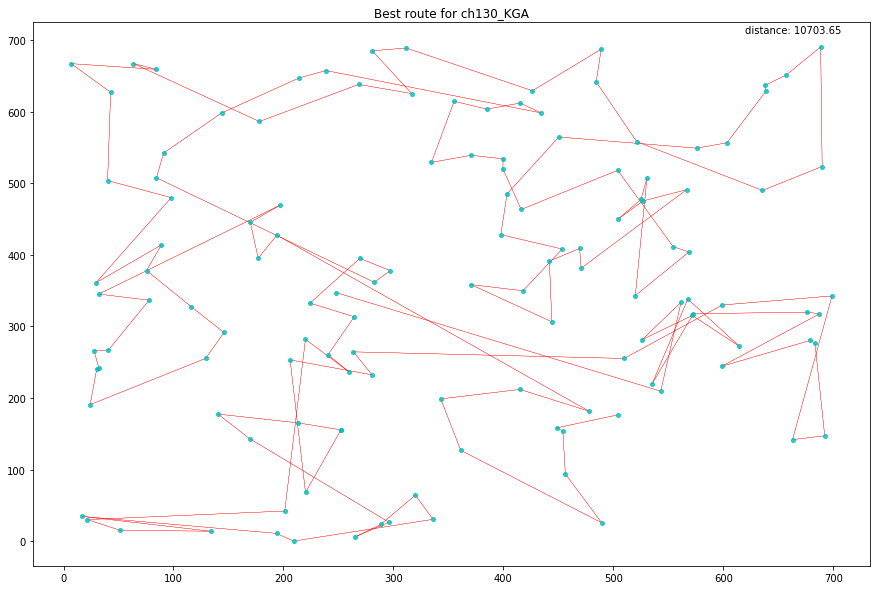

In [37]:
rcParams['figure.figsize'] = 15,10
plot(df_ch130, clu_start, dist, 'ch130_KGA', save = False)

### d198

In [116]:
d_matrix = dist_matrix(df_d198)

list_dist = []
list_time = []
list_route = None
list_errp = []


best = 99999999
for run in range(0,nRun):

    #time
    start = time.time()


    ###########
    # cluster #
    ###########

    clustering = KMeans(n_clusters = 40, n_init = 100).fit(df_d198)
    results = clustering.labels_

    centroid_df = pd.DataFrame(clustering.cluster_centers_)
    centroids = []
    centroids = list(range(len(centroid_df)))
    d_matrixCentroid = dist_matrix(centroid_df)

    #1/routeFitness(centroids, d_matrixCentroid)

    #order cluster with shortest path (GA)
    ordered_centroids = GenA(centroids,
                             d_matrixCentroid, 
                             popSize = 100,
                             selection = 'roulette-wheel',
                             elite_n=25,
                             mutation_r=0.01,
                             n_of_gen = 100)[0]
    # and re-order
    obj = list_of_clusters(results)
    obj1 = []
    [obj1.append(obj[elem]) for elem in ordered_centroids]
    #print('done')


    ##################
    # GA --> cluster #
    ##################

    Clusterd198 = KGA(obj1,
                      dm = d_matrix,
                      popSize=100,
                      selection='roulette-wheel',
                      elite_n=25,
                      mutation_r=0.01,
                      n_of_gen=100,
                      plot = False)


    ################
    # join cluster #
    ################

    clu_start = Clusterd198[0]
    for i in range(1,len(Clusterd198)):
        clu_start = join_cluster(clu_start,Clusterd198[i], d_matrix)

    dist = 1/routeFitness(clu_start, d_matrix)

    end = time.time()
    time_ex = end-start

    
    if dist < best:
        list_route = clu_start[:]
        best = dist

    errp = errPerc(bestKnown_tsp['d198'], dist, 2)
    # print(dist)
    # print('With an error to minimal value of: {}%'.format(errp))
    list_dist.append(dist)
    list_time.append(time_ex)
    list_errp.append(errp)





#insert in list for final results (best, mean, std)
list_dist_avg.append(mean(list_dist))
list_dist_best.append(min(list_dist))
list_dist_std.append(stdev(list_dist))
list_errp_avg.append(mean(list_errp))
list_errp_best.append(errPerc(bestKnown_tsp['d198'], min(list_dist), 2))
list_time_avg.append(mean(list_time))
list_route_final.append(list_route)

c:\users\massi\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [117]:
list_errp_avg, list_dist_avg, list_errp_best, list_dist_best #k=20, k=30, k=40

([58.937999999999995, 44.214, 59.812],
 [25080.30652819391, 22756.858120212368, 25218.108595436526],
 [35.41, 34.58, 49.41],
 [21367.046046171326, 21237.02228531626, 23577.060982669173])

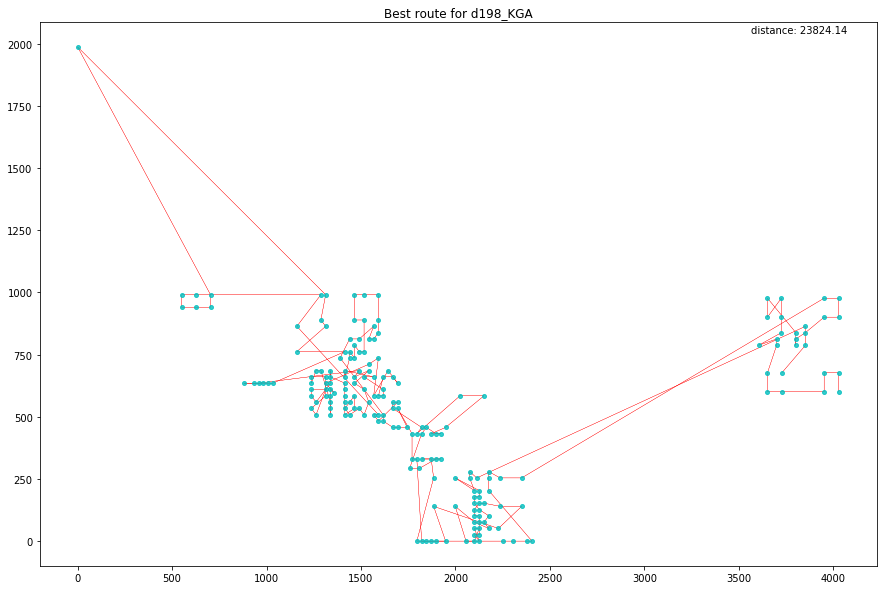

In [39]:
rcParams['figure.figsize'] = 15,10
plot(df_d198, clu_start, dist, 'd198_KGA', save = False)

## pr1002

In [40]:
d_matrix = dist_matrix(df_pr1002)

list_dist = []
list_time = []
list_route = None
list_errp = []


best = 99999999
for run in range(0,nRun):

    #time
    start = time.time()


    ###########
    # cluster #
    ###########

    clustering = KMeans(n_clusters = 30, n_init = 100).fit(df_pr1002)
    results = clustering.labels_

    centroid_df = pd.DataFrame(clustering.cluster_centers_)
    centroids = []
    centroids = list(range(len(centroid_df)))
    d_matrixCentroid = dist_matrix(centroid_df)

    #1/routeFitness(centroids, d_matrixCentroid)

    #order cluster with shortest path (GA)
    ordered_centroids = GenA(centroids,
                             d_matrixCentroid, 
                             popSize = 100,
                             selection = 'roulette-wheel',
                             elite_n=25,
                             mutation_r=0.01,
                             n_of_gen = 10)[0]
    # and re-order
    obj = list_of_clusters(results)
    obj1 = []
    [obj1.append(obj[elem]) for elem in ordered_centroids]
    #print('done')


    ##################
    # GA --> cluster #
    ##################

    Clusterpr1002 = KGA(obj1,
                      dm = d_matrix,
                      popSize=100,
                      selection='roulette-wheel',
                      elite_n=25,
                      mutation_r=0.01,
                      n_of_gen=10,
                      plot = False)


    ################
    # join cluster #
    ################

    clu_start = Clusterpr1002[0]
    for i in range(1,len(Clusterpr1002)):
        clu_start = join_cluster(clu_start,Clusterpr1002[i], d_matrix)

    dist = 1/routeFitness(clu_start, d_matrix)

    end = time.time()
    time_ex = end-start

    
    if dist < best:
        list_route = clu_start[:]
        best = dist

    errp = errPerc(bestKnown_tsp['pr1002'], dist, 2)
    # print(dist)
    # print('With an error to minimal value of: {}%'.format(errp))
    list_dist.append(dist)
    list_time.append(time_ex)
    list_errp.append(errp)





#insert in list for final results (best, mean, std)
list_dist_avg.append(mean(list_dist))
list_dist_best.append(min(list_dist))
list_dist_std.append(stdev(list_dist))
list_errp_avg.append(mean(list_errp))
list_errp_best.append(errPerc(bestKnown_tsp['pr1002'], min(list_dist), 2))
list_time_avg.append(mean(list_time))
list_route_final.append(list_route)

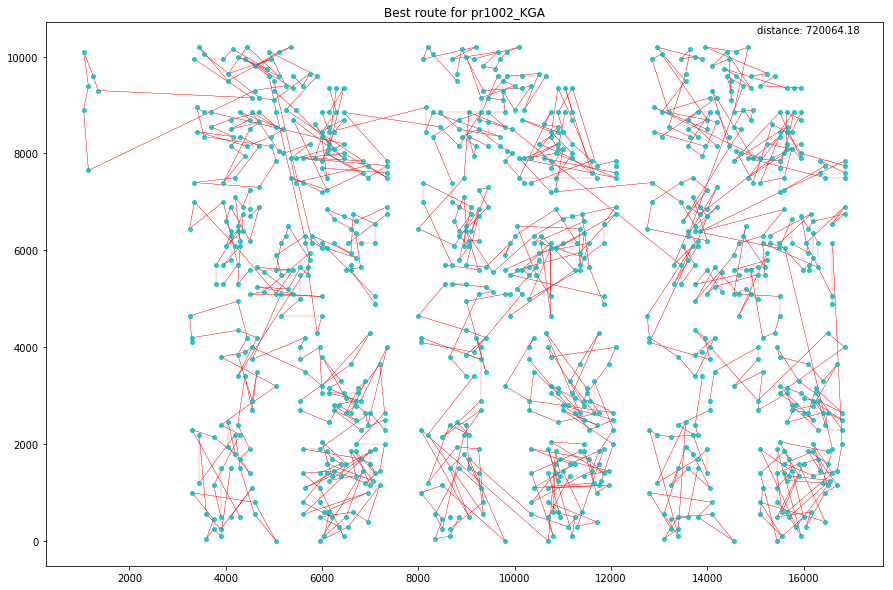

In [41]:
rcParams['figure.figsize'] = 15,10
plot(df_pr1002, clu_start, dist, 'pr1002_KGA', save = False)

## Results for KGA

In [42]:
ndx = list(bestKnown_tsp.keys())

In [43]:
list_best_dist_known = list(bestKnown_tsp.values())
list_tuples = list(zip(list_best_dist_known,list_dist_avg, list_dist_std, list_dist_best, list_errp_avg,
                      list_errp_best, list_time_avg))
results_KGA = pd.DataFrame(list_tuples, columns = ['OptimalTour', 'mean_KGA', 'sd_KGA', 'best_KGA', '%meanDist_KGA',
                                                 '%bestDist_KGA', 'avgTime(s)_KGA'], index = ndx)

#pd.options.display.float_format = '{:.2f}'.format
results_KGA

,OptimalTour,mean_KGA,sd_KGA,best_KGA,%meanDist_KGA,%bestDist_KGA,avgTime(s)_KGA
dj38,6656,13307.35,817.00,12227.88,99.93,83.71,1.64
berlin52,7542,10987.40,338.81,10571.44,45.68,40.17,2.60
ch130,6110,9873.74,558.84,9288.06,61.60,52.01,5.62
d198,15780,26710.27,3118.20,23824.14,69.27,50.98,10.42
pr1002,259045,719603.78,11479.81,700986.34,177.79,170.60,20.00


In [44]:
#save the route of best distance 
with open("BestRoute_KGA.txt", "w") as text_file:
    c = 0
    for i in results_KGA.index:
        print("The best route for {} is:\n{}\n\n".format(i, list_route_final[c]), file=text_file)
        c += 1

# Final Results

In [47]:
pd.options.display.float_format = '{:.2f}'.format 
df_final = pd.merge(results_GA, results_KGA, left_index=True, right_index=True, on='OptimalTour')
df_final

,OptimalTour,mean_GA,sd_GA,best_GA,%meanDist_GA,%bestDist_GA,avgTime(s)_GA,mean_KGA,sd_KGA,best_KGA,%meanDist_KGA,%bestDist_KGA,avgTime(s)_KGA
dj38,6656,14868.04,405.34,14234.01,123.38,113.85,0.16,13307.35,817.00,12227.88,99.93,83.71,1.64
berlin52,7542,18141.91,548.96,17527.20,140.54,132.39,0.19,10987.40,338.81,10571.44,45.68,40.17,2.60
ch130,6110,32703.79,519.60,31921.29,435.25,422.44,0.38,9873.74,558.84,9288.06,61.60,52.01,5.62
d198,15780,131782.66,3313.13,128903.40,735.12,716.88,0.62,26710.27,3118.20,23824.14,69.27,50.98,10.42
pr1002,259045,6134500.29,28304.42,6114804.78,2268.12,2260.52,0.98,719603.78,11479.81,700986.34,177.79,170.60,20.00


In [49]:
df_final.to_excel('finalResults.xlsx')

## overview

In [18]:
data = pd.read_csv('finalResults/finalResults.txt', index_col=0)
pd.options.display.float_format = '{:.3f}'.format
data.head()

,OptimalTour,mean_GA,sd_GA,best_GA,%meanDist_GA,%bestDist_GA,avgTime(s)_GA,mean_KGA,sd_KGA,best_KGA,%meanDist_KGA,%bestDist_KGA,avgTime(s)_KGA
dj38,6656,7032.915,574.337,6659.432,5.662,0.050,263.316,9608.767,1817.018,7720.027,44.362,15.990,140.053
berlin52,7542,8095.354,167.265,7868.717,7.336,4.330,285.814,8879.593,446.691,8218.954,17.738,8.980,188.052
ch130,6110,7933.021,1041.273,6929.814,29.838,13.420,434.955,7790.853,312.171,7314.084,27.510,19.710,408.724
d198,15780,27579.733,1869.538,25537.850,74.776,61.840,603.959,24023.858,3066.945,20830.943,52.242,32.010,1412.776
pr1002,259045,4666413.090,12608.566,4652556.084,1701.390,1696.040,2640.882,379495.874,6343.570,373865.263,46.498,44.320,4456.372
